In [1]:
# Load data
import csv
import numpy as np

X = np.loadtxt('data/hitters.x.csv', delimiter=',', skiprows=1)

with open('data/hitters.x.csv','r') as f:
    X_colnames = next(csv.reader(f))
    
y = np.loadtxt('data/hitters.y.csv', delimiter=',', skiprows=1)

## Why scale data to mean 0 and variance 1

We scale the data such that: $E[X] = 0$ and $Var[X] = E[X^2] - E[X]^2 = E[X^2] = 1$

1. Calculating variance is easier
2. Adding multiple random variables have the same impact
3. Easier to compare when variables are measured in different units


In [2]:
#print(X_colnames)

#print(X)

for column in X.T:
    Xmean = np.mean(column)
    Xstd = np.std(column)
    column -= Xmean
    column /= Xstd

# Check the transformations are ok
for column in X.T:
    #print('mean:', np.mean(column))
    assert np.mean(column) <0.01 and np.mean(column) > -0.01
    #print('variance:', np.var(column))
    assert np.var(column) < 1.01 and np.var(column) > 0.99
    
#print(X)

In [3]:
# Add ones before to normalized X array and create  [1|X]

Xh = np.concatenate( (np.ones(X.shape[0])[:, np.newaxis], X), axis=1)
#print(Xh)

#inv = np.linalg.inv(Xh.T@Xh)
#print(inv)

In [13]:
# Generate equidistant points
points = np.linspace(10**-3,10**7,num=100)
# take log of them
points_log = np.log(points)

from sklearn import linear_model

# array for normes of the coefficients
coef_norms = np.zeros(points.size, dtype=float)

rols = linear_model.LinearRegression().fit(X,y)
#print("OLS: ", rols.coef_)

for i in range(len(points)):
    # ridge regression with the next lambda
    reg = linear_model.Ridge(alpha=points[i])
    reg = reg.fit(X,y)

    #print(reg.coef_)
    norm = np.linalg.norm(reg.coef_)
    #print("Ridge: ", norm)
    coef_norms[i] = norm
    #print(reg.intercept_)

# take logs of norms
coef_norms_log = np.log(coef_norms)

# Printed coefficient values are for sub-exercise 4

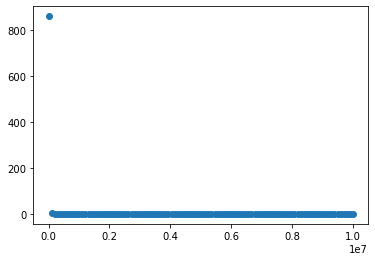

In [5]:
# Create the log log plot
import matplotlib
import matplotlib.pyplot as plt

#print(points)
#print(coef_norms)

plt.scatter(points,coef_norms)


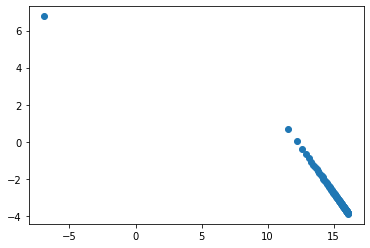

In [6]:
plt.scatter(points_log,coef_norms_log)

## K-Fold Cross Validation

1. Shuffle dataset
2. Split dataset into k groups
3. For each unique group:
    1. The group is taken as the test data set
    2. Remaining groups are the training data set
    3. Evaluate, save the score

In [7]:
# 5-Fold cross validation

datalen = y.size
indices = np.zeros(datalen, dtype=int)


for i in range(datalen):
    indices[i] = i
    
#shuffle indices
np.random.shuffle(indices)

# Each group has the same length first group is the first part etc.
grouplen = datalen//5
# last group gets some extra
excess = datalen % 5

#print(grouplen)
#print(excess)

# Split into 5 groups last group having a bit more elements
groupy = np.zeros((4,grouplen))
groupx = np.zeros((4,grouplen,19))

lastgroupy = np.zeros(grouplen+excess)
lastgroupx = np.zeros((grouplen+excess,19))

for k in range(4):
    for i in range(grouplen):
        groupy[k][i]=y[indices[k*grouplen + i]]
        groupx[k][i]=X[indices[k*grouplen + i]]
    
for i in range(4*grouplen, 5*grouplen + excess):
    lastgroupy[i - 4*grouplen] = y[indices[i]]
    lastgroupx[i - 4*grouplen] = X[indices[i]]
    
#print(groupy[1])
#print(groupx[1])

#print(lastgroupy)
#print(lastgroupx)

errors = np.zeros(100)

# for every i
for l in range(100):
    # Merge the groups and fit the data
    for k in range(4):
        #print(4)
        DX = lastgroupx
        Dy = lastgroupy
        for i in range(k):
            #print(i)
            DX = np.concatenate((DX,groupx[i]),axis=0)
            Dy = np.concatenate((Dy,groupy[i]),axis=0)
        for j in range(k+1,4):
            #print(j)
            DX = np.concatenate((DX,groupx[j]),axis=0)
            Dy = np.concatenate((Dy,groupy[j]),axis=0)

        #print(DX)
        #print(Dy)
        #print("============")

        reg = linear_model.Ridge(alpha=points[l])
        reg = reg.fit(DX,Dy)

        y_acc = 0.0
        for i in range(grouplen):
            y_pred = reg.predict(groupx[k][i].reshape(1, -1))
            y_acc += (y_pred - groupy[k][i]) * (y_pred - groupy[k][i])

        y_acc /= grouplen
        #print(y_acc)
        errors[l] += y_acc
        #now test it on our main group

    DX = np.concatenate((groupx[0],groupx[1],groupx[2],groupx[3]),axis=0)
    Dy = np.concatenate((groupy[0],groupy[1],groupy[2],groupy[3]),axis=0)

    reg = linear_model.Ridge(alpha=points[l])
    reg = reg.fit(DX,Dy)

    y_acc = 0.0
    for i in range(grouplen+excess):
        y_pred = reg.predict(lastgroupx[i].reshape(1, -1))
        y_acc += (y_pred -lastgroupy[i]) * (y_pred - lastgroupy[i])

    y_acc /= (grouplen+excess)
    #print(y_acc)
    errors[l] += y_acc

    errors[l] /= 5

    #print(errors[l])
    
    

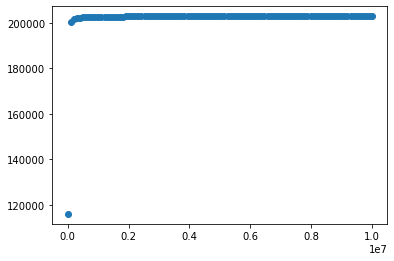

In [8]:
# Plot errors as a function
plt.scatter(points,errors)

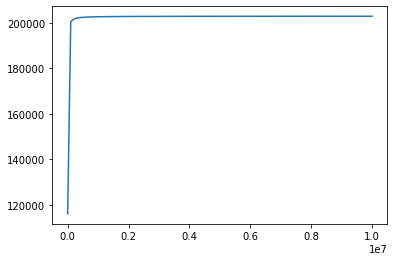

In [9]:
plt.plot(points,errors)

In [10]:
# Since the smallest value is has the least errors
# Fit one last time and report coefficients

reg = linear_model.Ridge(alpha=points[0])
reg = reg.fit(X,y)

print(reg.coef_)

[-291.07689885  337.76983981   37.817637    -60.51643708  -26.96167438
  135.05922913  -16.72927386 -390.81338172   86.882135    -14.05166346
  480.42919877  260.45660149 -213.84040958   31.24937094  -58.4169906
   78.76124192   53.72488332  -22.16403075  -12.35251465]


In [11]:
#Since all x and y are normalized we dont need to think about the units
# highest values are on intex 0,1,7,10,11,12

# this means focus to keep AtBat, Years, CRBI low and Hits, HmRuns and Cruns high,
# so focus on hitting and running? :D